<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Session12_TinyImagenet%26AnchorBox/ObjectDetect_BoundingBox_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Anchor box calculation 

### Description of the JSON file of bounding box annotation.
The main objects of the json file are:
1. **images** - contains details of each image checked for bounding box calculation. Details such as image file name, ID assigned, height and width of the uploaded image are present.

For example- first dog image has file name- 0.jpg and ID=0. The image has height and width of 375 and 500 pixels respectively.

2. **annotations** - annotations contain details for each object detected. If multiple objects are detected in a single image, then annotation details are captured for each of the objects. Annotation details contains id of the object, image id of the image where object was detected, category and bounding box details of each object. Bounding box include details such as top left x and y co-ordinate of the bounding box (housing the object), height and width of the bounding box.

    For example- Image name- 7.jpg has 2 objects (cat and dog detected) and details for each object is available. For the dog object's bounding box, the top left x and top left y co-ordinates are at 5 and 32 respectively.Width and height of the bounding box is 142 and 227.

3. **Categories**  - The categories object contains a list of categories (dog, cat) and each of those belongs to a supercategory. 

## Extract bounding box data from annotations.

In [19]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
cd '/gdrive/My Drive/Colab Notebooks/SchoolOfAI/ObjectDetection_boundingBox/'


/gdrive/My Drive/Colab Notebooks/SchoolOfAI/ObjectDetection_boundingBox


In [0]:
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [7]:
!ls

dog_boundingbox_export_coco.json  ObjectDetect_BoundingBox_Calculation.ipynb


In [42]:
with open('dog_boundingbox_export_coco.json', 'r') as fp:
    data = json.load(fp)
pprint(data.keys())

annotation_size = len(data["annotations"])
print("Number of annotations found:", annotation_size)
print("\nAnnotation example\n")
pprint(data["annotations"][0])

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])
Number of annotations found: 53

Annotation example

{'area': 93288,
 'bbox': [76, 20, 312, 299],
 'category_id': 1,
 'id': 0,
 'image_id': '0',
 'iscrowd': 0,
 'segmentation': [76, 20, 388, 20, 388, 319, 76, 319]}


In [0]:
annotations_df = pd.DataFrame(data["annotations"], columns = ['id','image_id','category_id'])
annotations_bbox_df = pd.DataFrame(data["annotations"], columns = ['bbox'])
annotations_bbox_df = pd.DataFrame(annotations_bbox_df.bbox.tolist(), columns=['x', 'y', 'w', 'h'])
annotations_df = pd.concat([annotations_df, annotations_bbox_df], axis=1)
images_df = pd.DataFrame(data["images"], columns = ['id', 'file_name', 'width', 'height'])

In [139]:
print(annotations_df[:10])
print(images_df[:10])

   id image_id  category_id    x   y    w    h
0   0        0            1   76  20  312  299
1   1        1            1   23  55  294  431
2   2        2            1   60  44  110  144
3   3        3            1   14   4  483  371
4   4        4            1   35   4  263  284
5   5        5            1  126   5  189  327
6   6        6            1   38   7  456  478
7   7        7            1    5  32  142  227
8   8        7            2  258  54   39  122
9   9        8            1   41   4  404  491
   id file_name  width  height
0   0     0.jpg    500     375
1   1     1.jpg    327     500
2   2     2.jpg    188     199
3   3     3.jpg    500     375
4   4     4.jpg    300     288
5   5     5.jpg    500     376
6   6     6.jpg    500     488
7   7     7.jpg    300     264
8   8     8.jpg    470     500
9   9     9.jpg    369     500


In [0]:
annotations_df.to_csv('file1.csv')
images_df.to_csv('file2.csv')

In [132]:
!ls

dog_bbox_data.csv		  file1.csv
dog_bbox_data.gsheet		  file2.csv
dog_boundingbox_export_coco.json  ObjectDetect_BoundingBox_Calculation.ipynb


In [0]:
bbox_df = pd.read_csv('dog_bbox_data.csv')

In [135]:
print(bbox_df[:10])

   id  image_id file_name  width  height  ...   y    w    h  norm_w  norm_h
0   0         0     0.jpg    500     375  ...  20  312  299  0.6240  0.7973
1   1         1     1.jpg    327     500  ...  55  294  431  0.8991  0.8620
2   2         2     2.jpg    188     199  ...  44  110  144  0.5851  0.7236
3   3         3     3.jpg    500     375  ...   4  483  371  0.9660  0.9893
4   4         4     4.jpg    300     288  ...   4  263  284  0.8767  0.9861
5   5         5     5.jpg    500     376  ...   5  189  327  0.3780  0.8697
6   6         6     6.jpg    500     488  ...   7  456  478  0.9120  0.9795
7   7         7     7.jpg    300     264  ...  32  142  227  0.4733  0.8598
8   8         7     7.jpg    300     264  ...  54   39  122  0.1300  0.4621
9   9         8     8.jpg    470     500  ...   4  404  491  0.8596  0.9820

[10 rows x 12 columns]


## Bounding height versus width

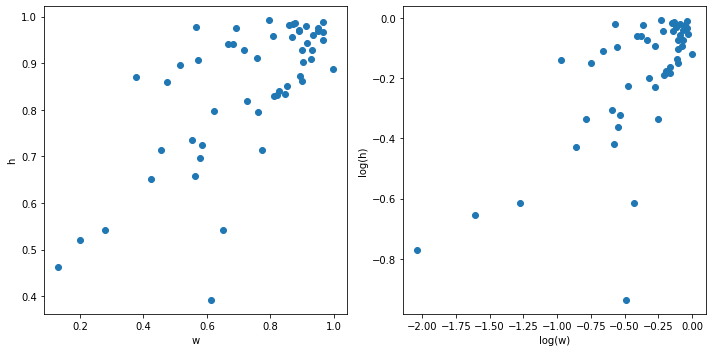

In [157]:
w, h = bbox_df["norm_w"], bbox_df["norm_h"]
log_w, log_h = np.log(w), np.log(h)

fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(10, 5))
axes[0].scatter(w, h)
axes[0].set_xlabel("w")
axes[0].set_ylabel("h")

axes[1].scatter(log_w, log_h)
axes[1].set_xlabel("log(w)")
axes[1].set_ylabel("log(h)")
fig.tight_layout()


## Calculate clusters

From elbow method, the optimum cluster is found to be 3. 

In [0]:
X= []
for i in range(len(log_w)):
    X.append((log_w[i], log_h[i]))
X = np.array(X)

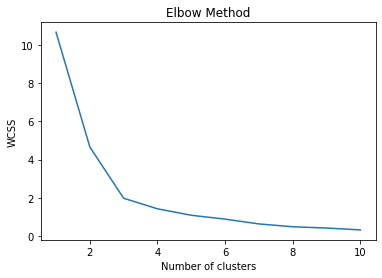

In [174]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

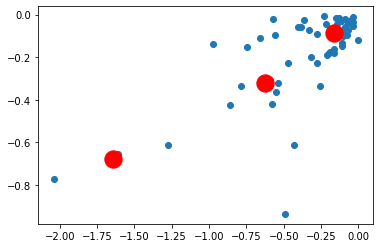

In [179]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()